# Univariate Time Series Forecasting with Exogenous Variables

Version: 22/03/2023

In this set of notebooks, we will cover modeling with exogenous variables. Our plan of action is as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes.
3. Build a univariate model with all exogenous variables to check best possible performance.
4. Evaluate the model with exogenous variables and discuss any potential issues.
5. Overcome issues identified above.
6. Make future predictions with the best model.
7. Replicate flow with Automated Time Series Modeling (AutoML)


Let us see if this synchronizes with Colab?

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [ ]:
# Google Drive connection
from google.colab import drive
drive.mount('/content/drive')

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.16 (main, Mar  8 2023, 04:29:24)  [Clang 14.0.6 ]
executable: /Users/tobiassiegfried/anaconda3/envs/pycaret_env_39/bin/python
   machine: macOS-13.2.1-arm64-arm-64bit

PyCaret required dependencies:
                 pip: 23.0.1
          setuptools: 60.10.0
             pycaret: 3.0.0
             IPython: 7.34.0
          ipywidgets: 7.7.4
                tqdm: 4.64.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.9.3
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.0.9
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.2
          matplotlib: 3.6.3
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.1
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.3
          

# Packages

In [3]:
import numpy as np
import pandas as pd
#from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

# Settings

Global figure settings

In [4]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

Global figure settings with plotly option

# Data

In [5]:
#file_path = '/content/drive/MyDrive/colab_nb/pycaret_3/q_16936_xreg_wide.csv'
file_path = "./q_16936_xreg_wide.csv"
# /My Drive/colab_nb/pycaret_3/q_16936_xreg_wide.csv
q_16936_xreg_wide = pd.read_csv(file_path)
q_16936_xreg_wide["index"] = pd.to_datetime(q_16936_xreg_wide["date"])
q_16936_xreg_wide.drop(columns=["date"], inplace=True)
target = "q_16936"
q_16936_xreg_wide.head()

,q_16936,scf_16924,scf_16059,scf_16938,index_NAO,index_PDO,index
0,173.0,0.915659,1.057488,1.078578,0.25,0.60,2001-01-31
1,169.0,0.933342,1.072396,1.087249,0.45,0.29,2001-02-28
2,202.0,0.900472,0.861495,0.763271,-1.26,0.45,2001-03-31
3,329.0,0.547575,0.462854,0.476981,0.00,-0.31,2001-04-30
4,761.0,-0.009636,-0.222963,-0.116112,-0.02,-0.30,2001-05-31


The dataset has no missing values as this has been taken care of in the data preparation step taken care of in R. Now, let's go on to our EDA and modeling. 

We now subset to only the relevant variables

In [6]:
q_16936_xreg_wide = q_16936_xreg_wide[['index', 'q_16936', 'scf_16059', 'index_NAO', 'index_PDO']]
q_16936_xreg_wide.head()

,index,q_16936,scf_16059,index_NAO,index_PDO
0,2001-01-31,173.0,1.057488,0.25,0.60
1,2001-02-28,169.0,1.072396,0.45,0.29
2,2001-03-31,202.0,0.861495,-1.26,0.45
3,2001-04-30,329.0,0.462854,0.00,-0.31
4,2001-05-31,761.0,-0.222963,-0.02,-0.30


# Exploratory Data Analysis (EDA)

In [7]:
# Create an EDA experiment ----
eda = TSForecastingExperiment()

This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function.

In [8]:
eda.setup(
    data=q_16936_xreg_wide,
    target=target,
    index="index",
    fh=12,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    transform_target = "log",
    scale_target = "zscore",
    # Set defaults for the plots ----
    fig_kwargs=global_fig_settings,
    session_id=42
)

Even before proceeding, we can observe some useful information here.

1. The data is an monthly dataset, hence a seasonal period of 12 was tested. Seasonality was detected at this time period.
2. While modeling, it is not recommended that the data be differenced (d=0 and D=0) due to the nature of the data. We will evaluate this further during the EDA process.
3. We might want to try to transform and scale the target.

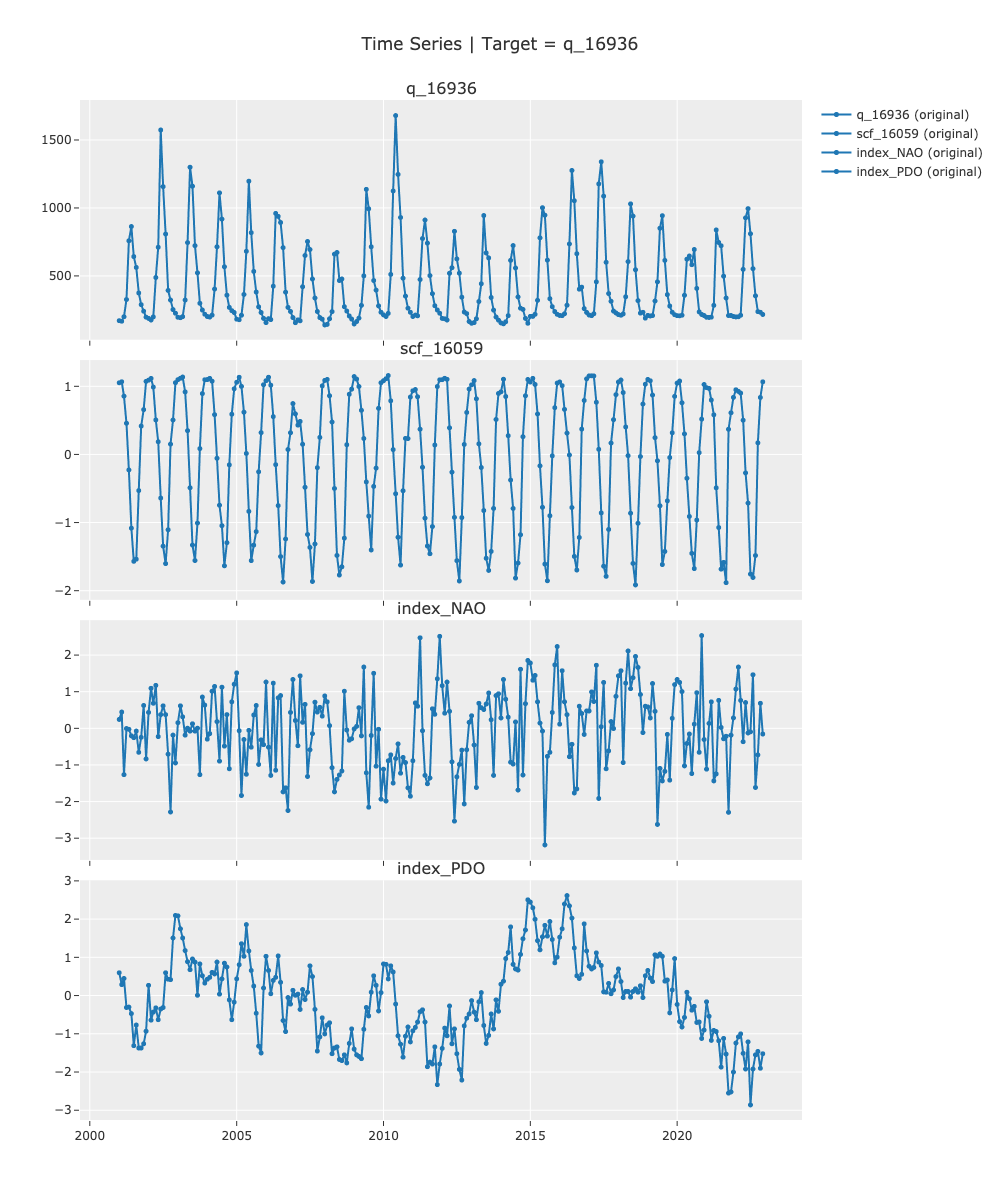

In [9]:
# Plot the target variable along with any exogenous variables ----
# Because the data is quite huge, plotting an interactive plot can slow down the notebook.
# Hence, we will revert to a static renderer for this plot
eda.plot_model(fig_kwargs={"renderer": "png", "width": 1000, "height": 1200})

In [10]:
# However, when you use the display_format `plotly-dash` or `plotly-widget`, 
# The plotly-resampler toolkit will be used as visualization back-end.
# This makes the plotly-visualization snappy and interactive by allowing data-aggregation 
# when you zoom in/out, datapoints are re-rendered for the region of interest.
# NOTE: Uncomment out display_format to use "plotly-widget".
eda.plot_model(
    plot="ts",
    fig_kwargs={
        'height': 1200,
        # With resampler_kwargs, the constructor of the plotly-resampler object
        # can be configured.
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            # show_dash kwargs withholds the kwargs of the show_dash (render) method.
            "show_dash": {"mode": "inline", "port": 8055},
        },
    },
    display_format="plotly-dash",
)

Dash is running on http://arm64-apple-darwin20.0.0:8055/



nodename nor servname provided, or not known


ConnectionError: HTTPConnectionPool(host='arm64-apple-darwin20.0.0', port=8055): Max retries exceeded with url: /_alive_ae5dd099-3e91-408e-9311-510a96ca41ab (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x2a31c2e80>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

While it may be hard to see the details in the zoomed out plot, pycaret provides the ability to zoom in using interactive plotly plots. 

Let's see how differencing looks like and if it is necessary. In addition to the differenced data, we will also plot some diagnostics such as ACF, PACF and Periodogram. While many readers will be aware of ACF and PACF, some more light may need to be shed on the periodogram. Periodogram is a plot that plots the spectral density in a time series as a function of frequency. The frequency in this case ranges from 0 to 0.5 (Minimum points required to measure a frequency is 2 which corresponds to a max frequency of 0.5). The magnitude at the various frequencies can be used to derive important characteristics about the time series. We will see this below.

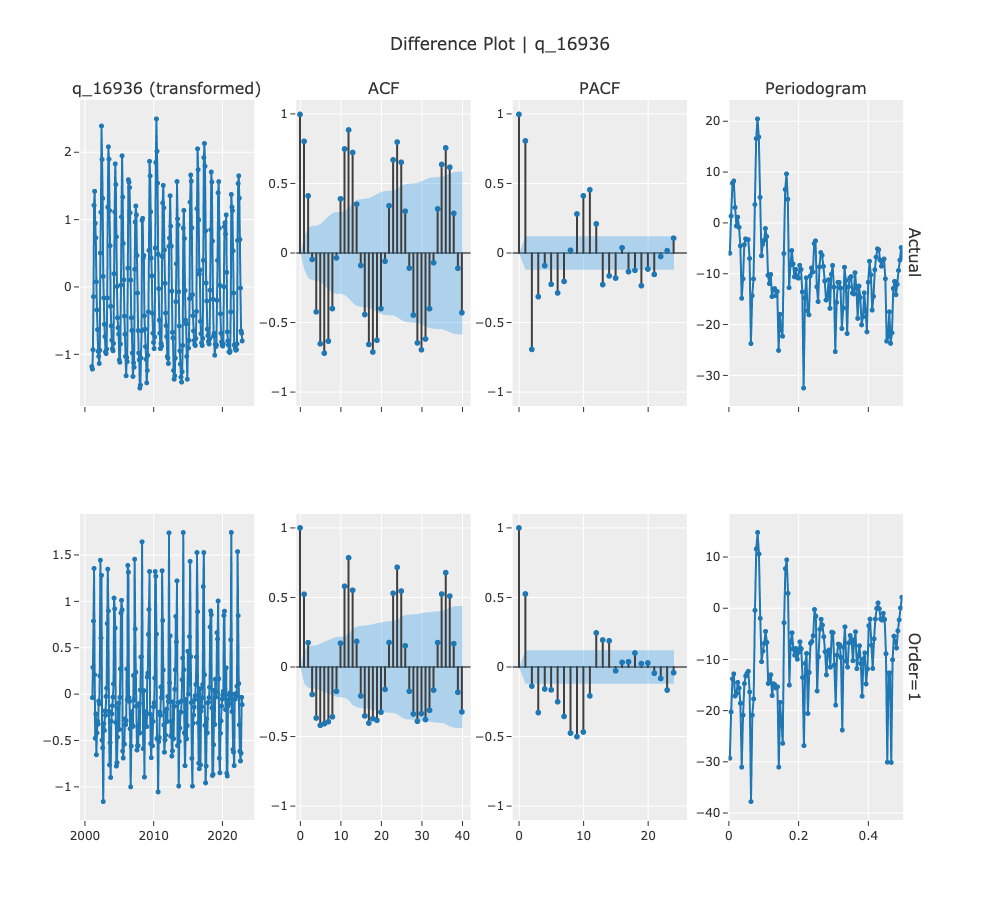

In [12]:
# Plots original data with first difference (order d = 1) by default
# NOTE: Uncomment out display_format to use "plotly-widget".
eda.plot_model(
    plot = "diff",
    fig_kwargs={
        "height": 900,
        # No need to pass show_dash kwargs when using a plotly-widget
        "resampler_kwargs": {"default_n_shown_samples": 1500 }
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    #display_format="plotly-widget",
)


The plots above show some interesting characteristics.

**Original - Plot Upper Row**
1. Do we need differencing? 
  - The dataset shows extended autocorrelations (ACF - row 1, col 2) which are well above the significance level. This points to the need for differencing.
  - The same observation can be derived by looking at the PACF plot as well (row 1 col 3) which shows a very high correlation on lag 1 (i.e. previous time point).
  - Note: this is from the tutorial and does not applye here. This characteristic can also be seen in the Periodogram (row 1, col 4) which shows a peak at ~ f = 0 (zoom in to see details). Peaking at ~ f = 0 means that the time period is very large (no repetitions) and is indicative of "random walk" type of behavior that can be modeling by differencing.
2. Do we need to model seasonality?
  - ACF also shows peaking at a lag of 12 indicative of seasonality of 12 (which was also indicated in the setup phase). 
  - This can also be seen in the periodogram (peaking at a fundamental f = 0.08333 (and it's harmonics). f = 0.08333 corresponds to T = 1/0.08333 = 12 indicating a seasonal period of 12 months.

**Order = 1 Difference - Plot Lower Row**
1. Order = 1 differencing shows that a lot of the extended autocorrelations have been taken care of (magnitude in row 2, col 2 is much less than before). The same is visible in the periodogram (row 2, col 4) where the magnitude at ~ f = 0 is much less than before.
2. ACF still shows peaking at a lag = 12 and so does the periodogram indicating that we still need to take care of this to model the behavior appropriately. Let's do that next by plotting the differences including the seasonality. This time, we will specify the lags explicitly as we want finer control over the analysis.

NOTE: lags = 1 is same as order = 1 meaning first difference, whereas lags = [1, 12] implies that first a first difference is taken and then a seasonal difference of 12 is taken.

In [13]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 12]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    display_format='plotly-dash',
)


Dash is running on http://arm64-apple-darwin20.0.0:8056/



nodename nor servname provided, or not known


ConnectionError: HTTPConnectionPool(host='arm64-apple-darwin20.0.0', port=8056): Max retries exceeded with url: /_alive_ae5dd099-3e91-408e-9311-510a96ca41ab (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1783bd6d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

We will bring our attention to the 3rd row since the first 2 are the repeat of the last plot. The 3rd row represents a first order difference followed by a seasonal difference of 12. As can be see from the ACF (row 3, col 2), all the extended autocorrelations have been taken care of. We still see a peak at lag = 12 (negative now), but on careful examination of the periodogram, we realize that the leaks have a very low spectral density. Hence, we can conclude that taking the first difference and a seasonal difference of 12 can model this time series fairly reasonably. 

Next, lets explore the effect of the exogenous variables on the target and the correlation between the variables. This can be accomplished with the help of Cross Correlation Plots.

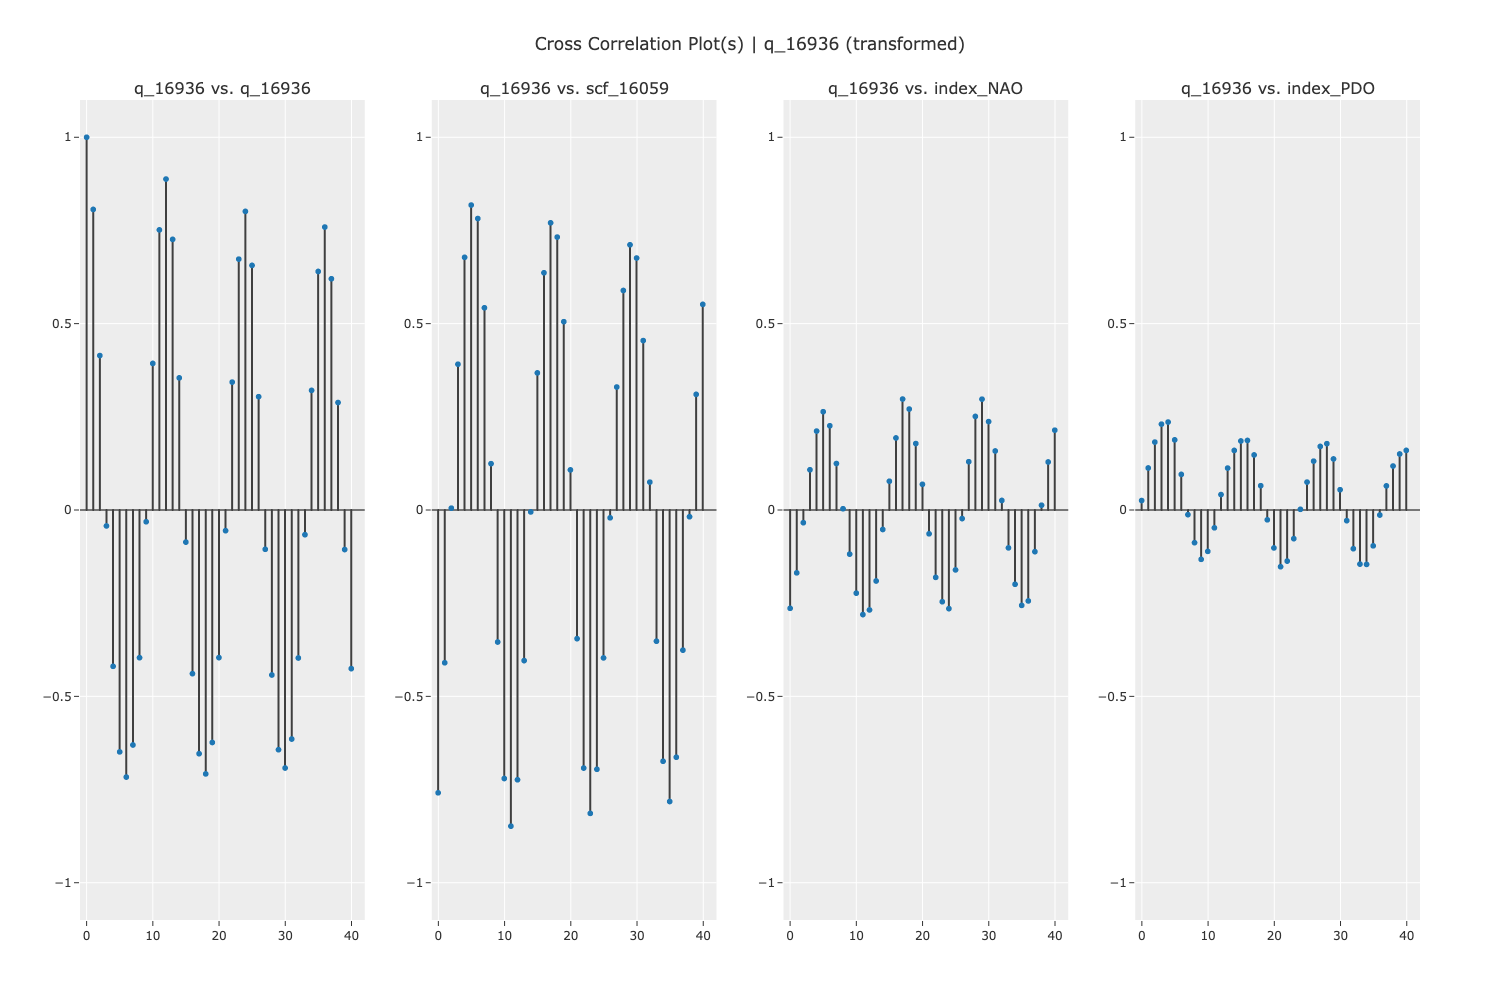

In [14]:
eda.plot_model(plot="ccf", fig_kwargs={"height": 1000, "width": 1500})

The first plot (row 1, col 1) shows self correlation for the target (same as its ACF), while the rest of the plots show the correlation of the target to the lagged values of the exogenous variables. All of the fractional snow cover time series extracted from MODIS satellite data show strong cross-correlations. Conversely, the climate indices (NAO and PDO) do not show similarly strong cross-correlation as the fractional snow cover time series.

# Baseline Model (ARIMA)

This is the univariate baseline model without exogenous variables used for forecasting.

In [15]:
data_uni = q_16936_xreg_wide.copy()
data_uni.set_index("index", inplace=True)
data_uni = data_uni[target]

exp_uni = TSForecastingExperiment()
exp_uni.setup(
    data=data_uni, 
    fh=12,
    transform_target = "log",
    scale_target = "zscore",
    numeric_imputation_target="ffill", 
    numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, 
    session_id=42
)

,Description,Value
0,session_id,42
1,Target,q_16936
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(264, 1)"
5,Transformed data shape,"(264, 1)"
6,Transformed train set shape,"(252, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [16]:
model_auto_arima = exp_uni.create_model("auto_arima")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:16:01
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Auto ARIMA


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-12,0.5840,0.5421,57.4816,92.3494,0.1189,0.1108,0.8625
1,2019-12,0.8277,0.8297,79.1400,138.1162,0.1511,0.1332,0.4762
2,2020-12,0.4688,0.4498,44.4635,74.1587,0.0937,0.0918,0.9029
Mean,NaT,0.6269,0.6072,60.3617,101.5414,0.1212,0.1119,0.7472
SD,NaT,0.1496,0.1618,14.3024,26.9074,0.0235,0.0169,0.1923


Have a look at the model properties

In [17]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -29.830
Date:                            Fri, 24 Mar 2023   AIC                             73.660
Time:                                    21:16:52   BIC                             98.366
Sample:                                01-31-2001   HQIC                            83.602
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.247e-05   7.53e-05     -0.166      0.869      -0.000       0.000
ar.L1          1.2226      0.159      7.695      0.000       0.911       1.534
ar.L2         -0.2795      0.122     -2.293      0.022      -0.518      -0.041
ma.L1         -0.7448      0.145     -5.135      0.000      -1.029      -0.461
ar.S.L12       0.9984      0.001    743.655      0.000       0.996       1.001
ma.S.L12      -0.8679      0.052    -16.623      0.000      -0.970      -0.766
sigma2         0.0620      0.005     11.855      0.000       0.052       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                10.00
Prob(Q):                              0.89   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                             0.16
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

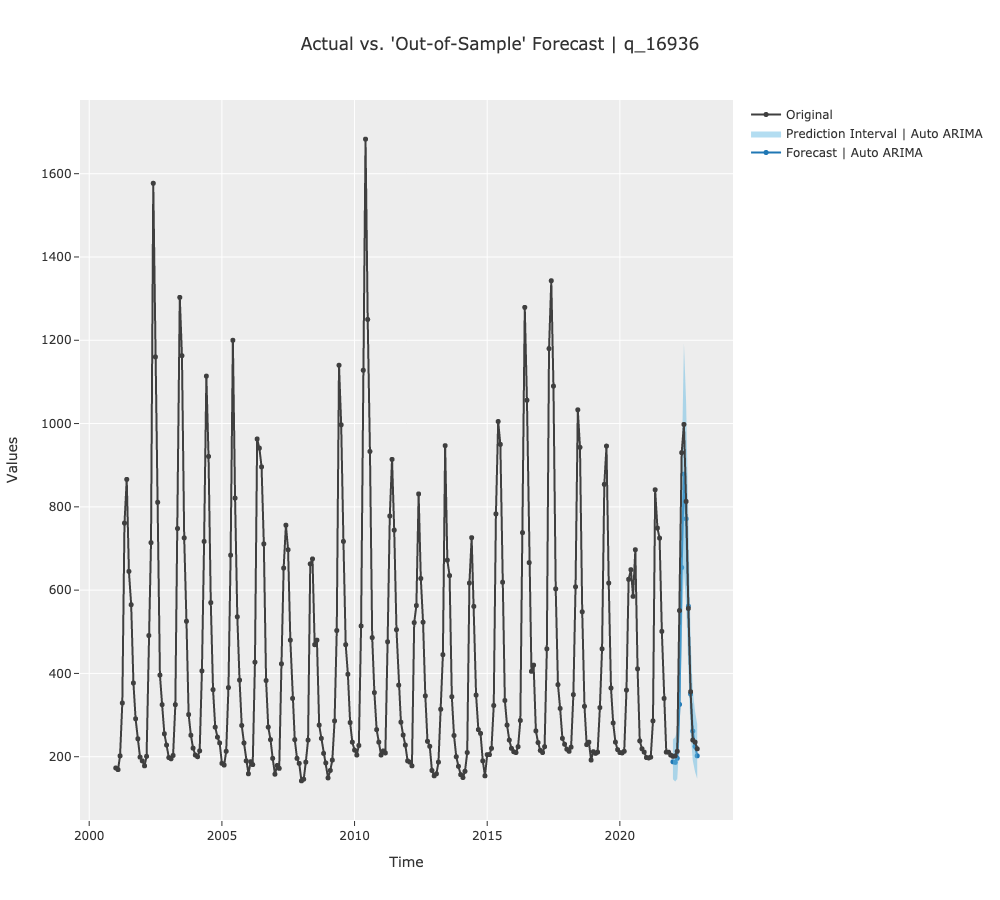

In [19]:
exp_uni.plot_model(model_auto_arima,
                    fig_kwargs={
                                "height": 900,
                                "resampler_kwargs": {
                                    "default_n_shown_samples": 1500,
                                    "show_dash": {"mode": "inline", "port": 8056},
                                    },
                       },
                    #display_format='plotly-dash'
                    )

In [20]:
exp_uni.plot_model(model_auto_arima,
                   plot='insample')

TypeError: X must be in an sktime compatible format, of scitype Series, Panel or Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. Allowed compatible mtype format specifications are: ['pd.Series', 'pd.DataFrame', 'np.ndarray', 'nested_univ', 'numpy3D', 'pd-multiindex', 'df-list', 'pd_multiindex_hier'] . See the data format tutorial examples/AA_datatypes_and_datasets.ipynb. If you think the data is already in an sktime supported input format, run sktime.datatypes.check_raise(data, mtype) to diagnose the error, where mtype is the string of the type specification you want. Error message for checked mtypes, in format [mtype: message], as follows: [pd.DataFrame: X should not have column of 'object' dtype]  [pd.Series: X must be a pandas.Series, found <class 'pandas.core.frame.DataFrame'>]  [np.ndarray: X must be a numpy.ndarray, found <class 'pandas.core.frame.DataFrame'>]  [dask_series: X must be a dask DataFrame, found <class 'pandas.core.frame.DataFrame'>]  [df-list: X must be list of pd.DataFrame, found <class 'pandas.core.frame.DataFrame'>]  [numpy3D: X must be a numpy.ndarray, found <class 'pandas.core.frame.DataFrame'>]  [pd-multiindex: X must have a MultiIndex, found <class 'pandas.core.indexes.period.PeriodIndex'>]  [nested_univ: X entries must be pd.Series]  [dask_panel: X must be a dask DataFrame, found <class 'pandas.core.frame.DataFrame'>]  [pd_multiindex_hier: X must have a MultiIndex, found <class 'pandas.core.indexes.period.PeriodIndex'>]  [dask_hierarchical: X must be a dask DataFrame, found <class 'pandas.core.frame.DataFrame'>] 


# Improved ARIMA Model - Univariate forecasting with exogenous variables

In [21]:
exp_xreg = TSForecastingExperiment()
exp_xreg.setup(
    data=q_16936_xreg_wide, 
    target=target, 
    index="index", 
    fh=12,
    transform_target = "log",
    scale_target = "zscore",
    numeric_imputation_target="ffill", 
    numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, 
    session_id=42
)

,Description,Value
0,session_id,42
1,Target,q_16936
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(264, 4)"
5,Transformed data shape,"(264, 4)"
6,Transformed train set shape,"(252, 4)"
7,Transformed test set shape,"(12, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [22]:
model_xreg = exp_xreg.create_model("arima", order=(1,0,2), seasonal_order=(1,0,1,12))

In [23]:
model_xreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  252
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 -39.129
Date:                              Fri, 24 Mar 2023   AIC                             98.257
Time:                                      21:17:31   BIC                            133.551
Sample:                                  01-31-2001   HQIC                           112.459
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.47e-05      0.001      0.039      0.969      -0.002       0.002
scf_16059     -0.3109      0.073     -4.287      0.000      -0.453      -0.169
index_NAO      0.0180      0.015      1.205      0.228      -0.011       0.047
index_PDO      0.0441      0.035      1.259      0.208      -0.025       0.113
ar.L1          0.9619      0.032     30.418      0.000       0.900       1.024
ma.L1         -0.4043      0.067     -5.996      0.000      -0.537      -0.272
ma.L2         -0.2219      0.066     -3.380      0.001      -0.351      -0.093
ar.S.L12       0.9859      0.006    161.890      0.000       0.974       0.998
ma.S.L12      -0.7286      0.049    -14.831      0.000      -0.825      -0.632
sigma2         0.0712      0.006     11.548      0.000       0.059       0.083
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.51
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

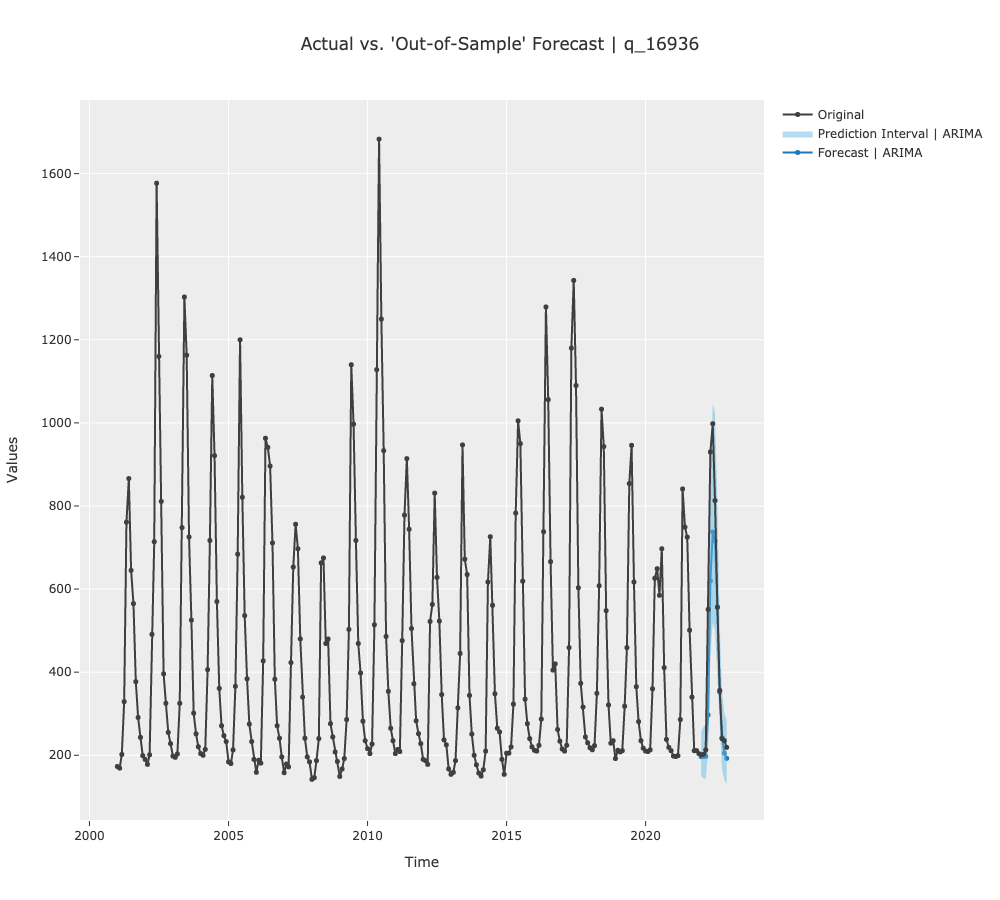

In [25]:
exp_xreg.plot_model(model_xreg,
                    fig_kwargs={
                                "height": 900,
                                "resampler_kwargs": {
                                    "default_n_shown_samples": 1500,
                                    "show_dash": {"mode": "inline", "port": 8056},
                                    },
                       },
                    #display_format='plotly-dash'
                    )

The above model with exogenous regressors does indeed slightly benefit from xregs that are added here.

In [26]:
exp_xreg.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,264.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,0.0
3,Summary,Statistics,Transformed,Median,,-0.345333
4,Summary,Statistics,Transformed,Standard Deviation,,1.001899
5,Summary,Statistics,Transformed,Variance,,1.003802
6,Summary,Statistics,Transformed,Kurtosis,,-0.963286
7,Summary,Statistics,Transformed,Skewness,,0.543524
8,Summary,Statistics,Transformed,# Distinct Values,,206.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",2108.229557


# Big Model Showdown with compare_models()

And compare models. This function trains and evaluates the performance of all estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

What models are available? You can use the include and exclude parameter in the compare_models to train only select model or exclude specific models from training by passing the model id's in exclude parameter.

In [27]:
exp_xreg.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
croston,Croston,sktime.forecasting.croston.Croston,True
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True


In [ ]:
# create pyspark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# import parallel back-end
from pycaret.parallel import FugueBackend

#best = exp_xreg.compare_models(parallel = FugueBackend(spark))
best = exp_xreg.compare_models()

In [34]:
best = exp_xreg.compare_models(n_select=3)

In [36]:
best

[AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 NaiveForecaster(sp=12),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12, 11,
                                                                         10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=BayesianRidge(), sp=12, window_length=12)]

In [ ]:
exp_xreg.plot_model(best, plot = 'insample')

# Evaluate Model

We have managed to improve MASE a bit. Let's finalize the model by training it on the entire dataset so we can make true future forecasts.


In [37]:
final_model_xreg = exp_xreg.finalize_model(model_xreg)

In [38]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try: 
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

safe_predict(exp_xreg, final_model_xreg)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed in order to make future predictions:
['scf_16059', 'index_NAO', 'index_PDO']


As we can see, this approach does not come without side effects. The problem is that we have 5 exogenous variables. Hence in order to get any unknown future values for discharge, we will need the future values for all these exogenous variables. This is generally obtained through some forecasting process itself. But each forecast will have errors and these errors can be compounded when there are a lot of exogenous variables.

Let's see if we can trim down these exogenous variables to a handful of useful variables without compromising on forecasting performance.

# Parsimonious Model

From the CCF Analysis, we found that many of the exogenous variables show a very similar correlation structure to discharge. This particularly applies to the scf data. Instead of keeping all of them, we just pick `scf_16059`. Additionally, we keep the NOA 

E.g. PT08.S1(CO), NOx(GT), C6H6(GT), PT08.S2(NMHC) values from 24 hours before (lag = 24) show a high positive correlation to CO concentration. Instead of keeping all of them, lets pick the one with the highest positive correlation at lag 24 which is NOx(GT).

Similarly, PT08.S3(NOx) values from 24 hours ago shows the highest negative correlation to CO concentration. Let's keep this variable as well.

Finally, in daily cycles, what happens 12 hours back can also impact the current value (e.g. values last night can impact the next day and vice versa). The variable with the highest correlation to CO concentration at lag = 12 is RH. We will keep this as well.